# Word2vec Beginner

In [180]:
import tensorflow as tf

In [181]:
import urllib
import numpy as np
import collections
import math
import os
import random
import zipfile
import matplotlib.pyplot as plt

In [182]:
VOCAB_SIZE = 250000
VECTOR_SIZE = 300
BATCH_SIZE = 100
WINDOW_SIZE = 1
NUM_SKIPS = 2

In [104]:
# Step 1: Download the data.
url = 'http://mattmahoney.net/dc/'


def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urllib.urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    print(statinfo.st_size)
    raise Exception(
        'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)


('Found and verified', 'text8.zip')


In [105]:
# Read the data into a list of strings.
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data

words = read_data(filename)
print('Data size', len(words))

('Data size', 17005207)


In [106]:
print words[:20]

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english']


## Build Dataset

In [107]:
%%time
# Count array
UNK_INDEX = 0
count = [['UNK',-1]]
count.extend(collections.Counter(words).most_common(VOCAB_SIZE-1))

CPU times: user 6.38 s, sys: 160 ms, total: 6.54 s
Wall time: 6.41 s


In [108]:
count[:10]

[['UNK', -1],
 ('the', 1061396),
 ('of', 593677),
 ('and', 416629),
 ('one', 411764),
 ('in', 372201),
 ('a', 325873),
 ('to', 316376),
 ('zero', 264975),
 ('nine', 250430)]

In [109]:
%%time
dictionary = dict()
for word, _ in count:
    dictionary[word] = len(dictionary)

# will contain the indices to be used in our network
data = list()
unk_count = 0
for word in words:
    if word in dictionary:
        index = dictionary[word]
    else:
        index = UNK_INDEX
        unk_count += 1
    data.append(index)
    
count[0][1] = unk_count

reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

CPU times: user 5.63 s, sys: 164 ms, total: 5.79 s
Wall time: 5.68 s


In [110]:
del words

In [179]:
print data[:10]
print [reverse_dictionary[i] for i in data[:10]]

SyntaxError: invalid syntax (<ipython-input-179-708eb5b4eef9>, line 1)

## Create Batch

In [112]:
data_index = 0
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert BATCH_SIZE % NUM_SKIPS == 0
    assert NUM_SKIPS <= 2 * WINDOW_SIZE
    batch = np.ndarray(shape=(BATCH_SIZE), dtype=np.int32)
    labels = np.ndarray(shape=(BATCH_SIZE,1), dtype=np.int32)
    span = 2 * WINDOW_SIZE + 1
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(BATCH_SIZE // NUM_SKIPS):
        target = WINDOW_SIZE  # target label at the center of the buffer
        targets_to_avoid = [WINDOW_SIZE]
        for j in range(NUM_SKIPS):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * NUM_SKIPS + j] = buffer[WINDOW_SIZE]
            labels[i * NUM_SKIPS + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)

In [113]:
len(batch)

100

In [114]:
for i in range(8):
    print(reverse_dictionary[batch[i]], '-> ', [reverse_dictionary[d] for d in labels[i,:] ] )

('originated', '-> ', ['anarchism'])
('originated', '-> ', ['as'])
('as', '-> ', ['a'])
('as', '-> ', ['originated'])
('a', '-> ', ['term'])
('a', '-> ', ['as'])
('term', '-> ', ['of'])
('term', '-> ', ['a'])


In [115]:
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

In [155]:
graph = tf.Graph()

with graph.as_default():

    # Input data.
    train_inputs = tf.placeholder(dtype=tf.int32, shape=[BATCH_SIZE])
    train_labels = tf.placeholder(dtype=tf.int32, shape=[BATCH_SIZE, WINDOW_SIZE])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    with tf.device("/gpu:0"):
        # W matrix
        embeddings = tf.Variable(initial_value=tf.random_uniform([VOCAB_SIZE, VECTOR_SIZE], -1.0, 1.0), dtype='float32')
        # actual embedding vector for the input word
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)
        
        # W' matrix
        nce_weights = tf.Variable(initial_value=tf.truncated_normal([VOCAB_SIZE, VECTOR_SIZE],
                      stddev=1.0 / math.sqrt(VECTOR_SIZE)))
        nce_biases = tf.Variable(tf.zeros([VOCAB_SIZE]))

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    nce_loss = tf.nn.nce_loss(nce_weights, nce_biases, embed, train_labels,
                 num_sampled, VOCAB_SIZE)
    loss = tf.reduce_mean(nce_loss)

    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
#     optimizer = tf.train.AdamOptimizer(learning_rate=0.1).minimize(loss)


    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(
        valid_embeddings, normalized_embeddings, transpose_b=True)

    # Add variable initializer.
    init = tf.global_variables_initializer()


In [126]:
valid_embeddings.get_shape()

TensorShape([Dimension(16), Dimension(300)])

In [127]:
nce_loss.get_shape()

TensorShape([Dimension(100)])

In [134]:
num_steps = 30001

<IPython.core.display.Javascript object>


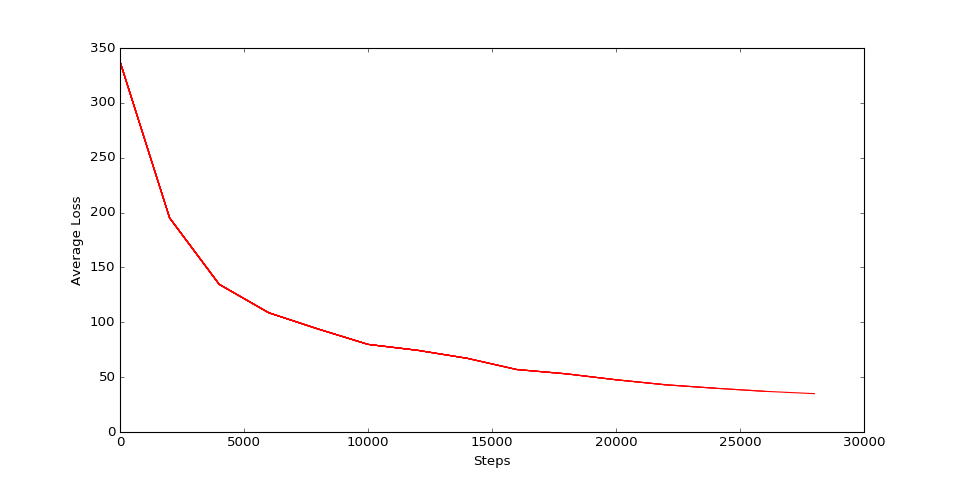

Initialized
('Average loss at step ', 0, ': ', 337.66693115234375)
Nearest to new: dokaka, guanabara, raggae, nterlocked, ekkhysis, dudu, pearce, pseudofossil,
Nearest to other: brackwater, nantosvelta, graff, minding, gaelscoileanna, jesulein, terraformer, instigates,
Nearest to will: canne, macginnis, bonspiel, siebold, dicotyledons, isoquinoline, cpl, prorogue,
Nearest to who: pyrrha, parco, softwoods, lettow, valge, homemakers, neuropath, yugo,
Nearest to had: brzezinka, walbrook, alberdi, mudstone, chhah, cloche, howes, escamoles,
Nearest to up: anusvaara, parcus, takah, nonconstructive, pentathlete, sellafield, maelstrom, fictiondom,
Nearest to at: cname, overplay, nonconservative, windsavers, jsot, cabinetmaker, fastes, grocery,
Nearest to world: baathist, juntas, wadham, overhanging, praznik, karstarks, graffiato, chromosomenzahlen,
Nearest to there: dissimilar, aethiopia, damodaran, bilandic, dermaptera, ionics, specialises, leberk,
Nearest to six: avventuriero, radiata, shara

In [156]:
%%time
%matplotlib notebook
losses = []
steps = []
fig = plt.figure(figsize=(12,6), dpi=80)
ax = plt.subplot(111)
ax.set_xlabel("Steps")
ax.set_ylabel("Average Loss")
with tf.Session(graph=graph) as session:
    init.run()
    print("Initialized")
    
    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(
            BATCH_SIZE, NUM_SKIPS, WINDOW_SIZE)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val
        
        # print loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            losses.append(average_loss)
            steps.append(step)
            ax.plot(steps, losses, 'r-')
            fig.canvas.draw()
            
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval() # Big 16 x V matrix
            for i in xrange(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = "Nearest to %s:" % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)
        
    final_embeddings = normalized_embeddings.eval()



In [136]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    #plt.savefig(filename)



In [137]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

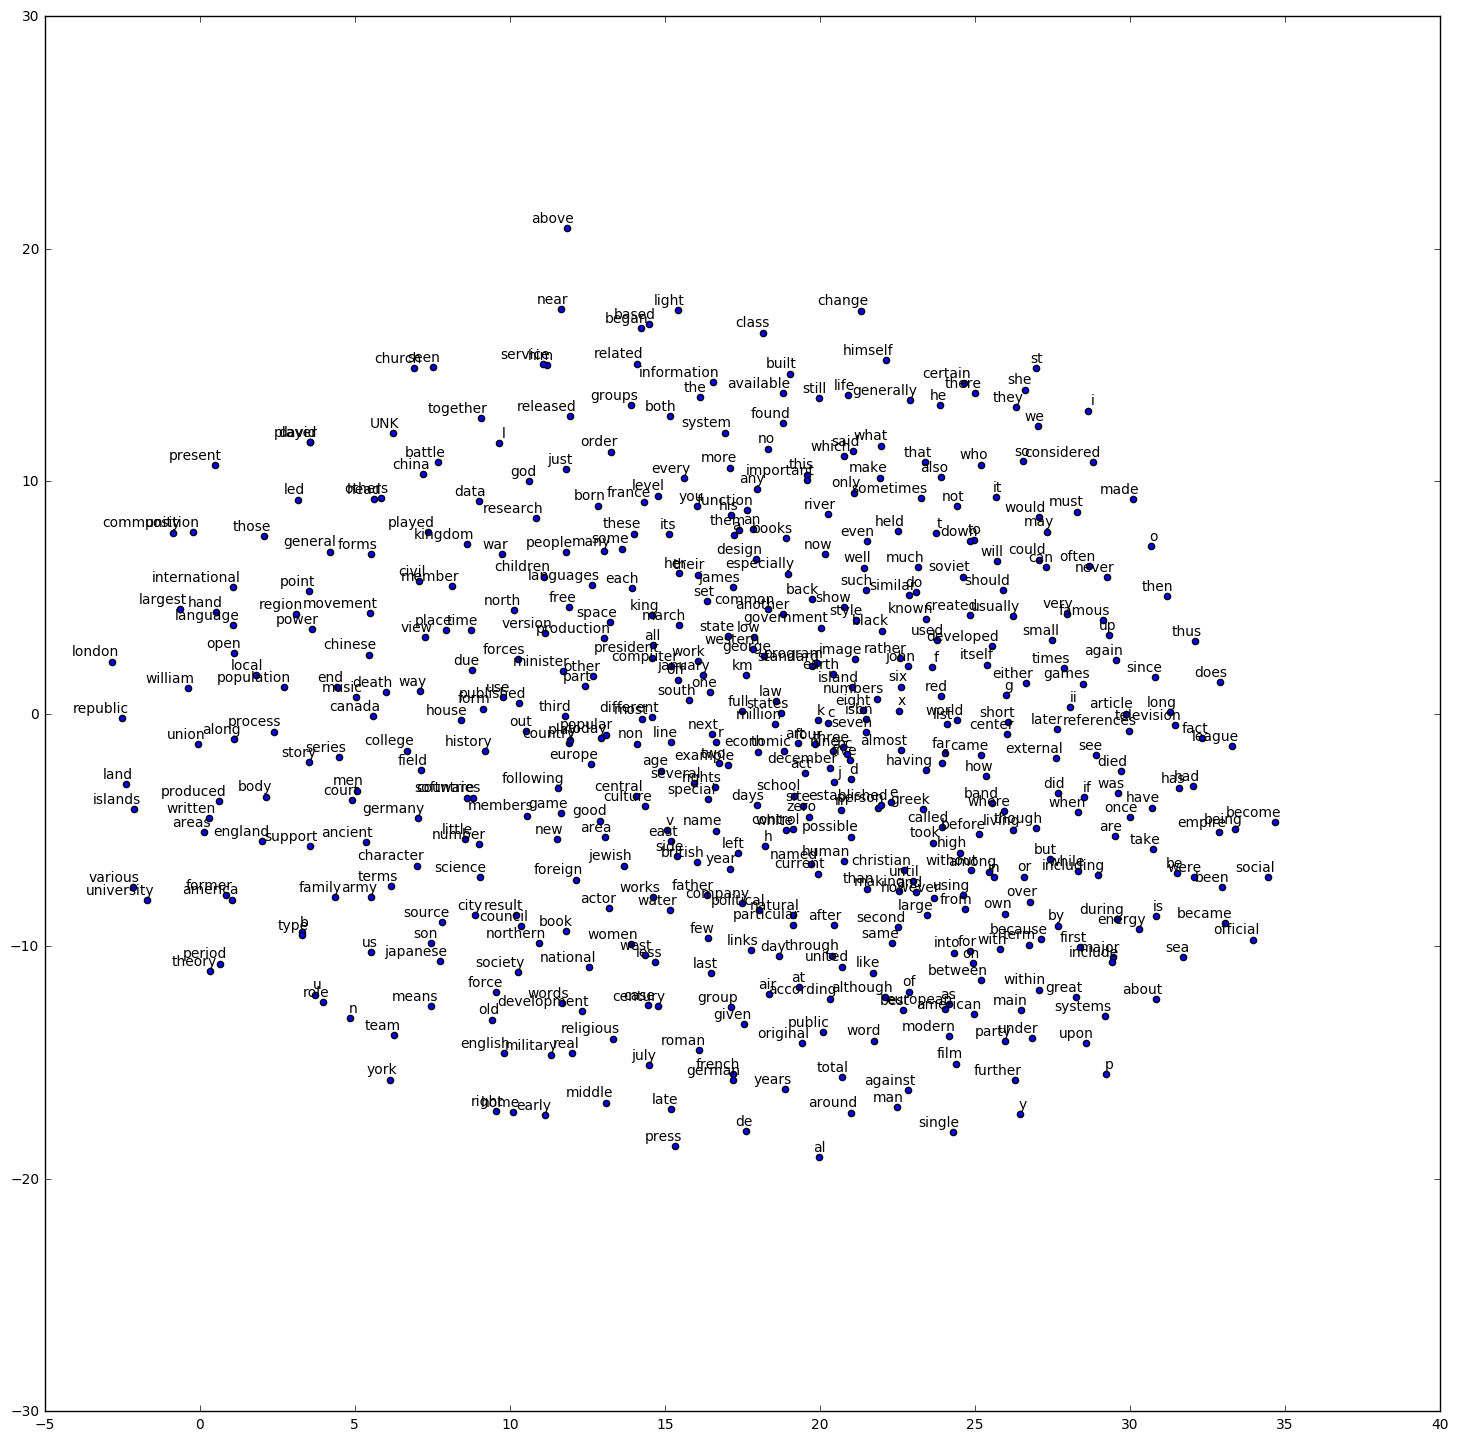

In [138]:
%matplotlib inline
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dictionary[i] for i in xrange(plot_only)]
plot_with_labels(low_dim_embs, labels)

# Word2vec optimized

In [161]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [174]:
import os
import sys
import threading
import time

from six.moves import xrange  # pylint: disable=redefined-builtin

import numpy as np
import tensorflow as tf

from tensorflow.models.embedding import gen_word2vec as word2vec
import argparse

tf.app.flags._global_parser = argparse.ArgumentParser()
flags = tf.app.flags

flags.DEFINE_string("save_path", None, "Directory to write the model and "
                    "training summaries.")
flags.DEFINE_string("train_data", None, "Training text file. "
                    "E.g., unzipped file http://mattmahoney.net/dc/text8.zip.")
flags.DEFINE_string(
    "eval_data", None, "File consisting of analogies of four tokens."
    "embedding 2 - embedding 1 + embedding 3 should be close "
    "to embedding 4."
    "See README.md for how to get 'questions-words.txt'.")
flags.DEFINE_integer("embedding_size", 200, "The embedding dimension size.")
flags.DEFINE_integer(
    "epochs_to_train", 15,
    "Number of epochs to train. Each epoch processes the training data once "
    "completely.")
flags.DEFINE_float("learning_rate", 0.2, "Initial learning rate.")
flags.DEFINE_integer("num_neg_samples", 100,
                     "Negative samples per training example.")
flags.DEFINE_integer("batch_size", 16,
                     "Number of training examples processed per step "
                     "(size of a minibatch).")
flags.DEFINE_integer("concurrent_steps", 16,
                     "The number of concurrent training steps.")
flags.DEFINE_integer("window_size", 5,
                     "The number of words to predict to the left and right "
                     "of the target word.")
flags.DEFINE_integer("min_count", 5,
                     "The minimum number of word occurrences for it to be "
                     "included in the vocabulary.")
flags.DEFINE_float("subsample", 1e-3,
                   "Subsample threshold for word occurrence. Words that appear "
                   "with higher frequency will be randomly down-sampled. Set "
                   "to 0 to disable.")
flags.DEFINE_boolean(
    "interactive", False,
    "If true, enters an IPython interactive session to play with the trained "
    "model. E.g., try model.analogy(b'france', b'paris', b'russia') and "
    "model.nearby([b'proton', b'elephant', b'maxwell'])")
flags.DEFINE_integer("statistics_interval", 5,
                     "Print statistics every n seconds.")
flags.DEFINE_integer("summary_interval", 5,
                     "Save training summary to file every n seconds (rounded "
                     "up to statistics interval).")
flags.DEFINE_integer("checkpoint_interval", 600,
                     "Checkpoint the model (i.e. save the parameters) every n "
                     "seconds (rounded up to statistics interval).")

FLAGS = flags.FLAGS

In [175]:
class Options(object):
    """Options used by our word2vec model."""

    def __init__(self):
        # Model options.

        # Embedding dimension.
        self.emb_dim = FLAGS.embedding_size

        # Training options.
        # The training text file.
        self.train_data = FLAGS.train_data

        # Number of negative samples per example.
        self.num_samples = FLAGS.num_neg_samples

        # The initial learning rate.
        self.learning_rate = FLAGS.learning_rate

        # Number of epochs to train. After these many epochs, the learning
        # rate decays linearly to zero and the training stops.
        self.epochs_to_train = FLAGS.epochs_to_train

        # Concurrent training steps.
        self.concurrent_steps = FLAGS.concurrent_steps

        # Number of examples for one training step.
        self.batch_size = FLAGS.batch_size

        # The number of words to predict to the left and right of the target word.
        self.window_size = FLAGS.window_size

        # The minimum number of word occurrences for it to be included in the
        # vocabulary.
        self.min_count = FLAGS.min_count

        # Subsampling threshold for word occurrence.
        self.subsample = FLAGS.subsample

        # How often to print statistics.
        self.statistics_interval = FLAGS.statistics_interval

        # How often to write to the summary file (rounds up to the nearest
        # statistics_interval).
        self.summary_interval = FLAGS.summary_interval

        # How often to write checkpoints (rounds up to the nearest statistics
        # interval).
        self.checkpoint_interval = FLAGS.checkpoint_interval

        # Where to write out summaries.
        self.save_path = FLAGS.save_path
        if not os.path.exists(self.save_path):
            os.makedirs(self.save_path)

        # Eval options.
        # The text file for eval.
        self.eval_data = FLAGS.eval_data


In [171]:
class Word2Vec(object):
    """Word2Vec model (Skipgram)."""

    def __init__(self, options, session):
        self._options = options
        self._session = session
        self._word2id = {}
        self._id2word = []
        self.build_graph()
        self.build_eval_graph()
        self.save_vocab()

    def read_analogies(self):
        """Reads through the analogy question file.
        Returns:
          questions: a [n, 4] numpy array containing the analogy question's
                     word ids.
          questions_skipped: questions skipped due to unknown words.
        """
        questions = []
        questions_skipped = 0
        with open(self._options.eval_data, "rb") as analogy_f:
            for line in analogy_f:
                if line.startswith(b":"):  # Skip comments.
                    continue
                words = line.strip().lower().split(b" ")
                ids = [self._word2id.get(w.strip()) for w in words]
                if None in ids or len(ids) != 4:
                    questions_skipped += 1
                else:
                    questions.append(np.array(ids))
        print("Eval analogy file: ", self._options.eval_data)
        print("Questions: ", len(questions))
        print("Skipped: ", questions_skipped)
        self._analogy_questions = np.array(questions, dtype=np.int32)

    def forward(self, examples, labels):
        """Build the graph for the forward pass."""
        opts = self._options

        # Declare all variables we need.
        # Embedding: [vocab_size, emb_dim]
        init_width = 0.5 / opts.emb_dim
        emb = tf.Variable(
            tf.random_uniform(
                [opts.vocab_size, opts.emb_dim], -init_width, init_width),
            name="emb")
        self._emb = emb

        # Softmax weight: [vocab_size, emb_dim]. Transposed.
        sm_w_t = tf.Variable(
            tf.zeros([opts.vocab_size, opts.emb_dim]),
            name="sm_w_t")

        # Softmax bias: [emb_dim].
        sm_b = tf.Variable(tf.zeros([opts.vocab_size]), name="sm_b")

        # Global step: scalar, i.e., shape [].
        self.global_step = tf.Variable(0, name="global_step")

        # Nodes to compute the nce loss w/ candidate sampling.
        labels_matrix = tf.reshape(
            tf.cast(labels,
                    dtype=tf.int64),
            [opts.batch_size, 1])

        # Negative sampling.
        sampled_ids, _, _ = (tf.nn.fixed_unigram_candidate_sampler(
            true_classes=labels_matrix,
            num_true=1,
            num_sampled=opts.num_samples,
            unique=True,
            range_max=opts.vocab_size,
            distortion=0.75,
            unigrams=opts.vocab_counts.tolist()))

        # Embeddings for examples: [batch_size, emb_dim]
        example_emb = tf.nn.embedding_lookup(emb, examples)

        # Weights for labels: [batch_size, emb_dim]
        true_w = tf.nn.embedding_lookup(sm_w_t, labels)
        # Biases for labels: [batch_size, 1]
        true_b = tf.nn.embedding_lookup(sm_b, labels)

        # Weights for sampled ids: [num_sampled, emb_dim]
        sampled_w = tf.nn.embedding_lookup(sm_w_t, sampled_ids)
        # Biases for sampled ids: [num_sampled, 1]
        sampled_b = tf.nn.embedding_lookup(sm_b, sampled_ids)

        # True logits: [batch_size, 1]
        true_logits = tf.reduce_sum(tf.mul(example_emb, true_w), 1) + true_b

        # Sampled logits: [batch_size, num_sampled]
        # We replicate sampled noise labels for all examples in the batch
        # using the matmul.
        sampled_b_vec = tf.reshape(sampled_b, [opts.num_samples])
        sampled_logits = tf.matmul(example_emb,
                                   sampled_w,
                                   transpose_b=True) + sampled_b_vec
        return true_logits, sampled_logits

    def nce_loss(self, true_logits, sampled_logits):
        """Build the graph for the NCE loss."""

        # cross-entropy(logits, labels)
        opts = self._options
        true_xent = tf.nn.sigmoid_cross_entropy_with_logits(
            true_logits, tf.ones_like(true_logits))
        sampled_xent = tf.nn.sigmoid_cross_entropy_with_logits(
            sampled_logits, tf.zeros_like(sampled_logits))

        # NCE-loss is the sum of the true and noise (sampled words)
        # contributions, averaged over the batch.
        nce_loss_tensor = (tf.reduce_sum(true_xent) +
                           tf.reduce_sum(sampled_xent)) / opts.batch_size
        return nce_loss_tensor

    def optimize(self, loss):
        """Build the graph to optimize the loss function."""

        # Optimizer nodes.
        # Linear learning rate decay.
        opts = self._options
        words_to_train = float(opts.words_per_epoch * opts.epochs_to_train)
        lr = opts.learning_rate * tf.maximum(
            0.0001, 1.0 - tf.cast(self._words, tf.float32) / words_to_train)
        self._lr = lr
        optimizer = tf.train.GradientDescentOptimizer(lr)
        train = optimizer.minimize(loss,
                                   global_step=self.global_step,
                                   gate_gradients=optimizer.GATE_NONE)
        self._train = train

    def build_eval_graph(self):
        """Build the eval graph."""
        # Eval graph

        # Each analogy task is to predict the 4th word (d) given three
        # words: a, b, c.  E.g., a=italy, b=rome, c=france, we should
        # predict d=paris.

        # The eval feeds three vectors of word ids for a, b, c, each of
        # which is of size N, where N is the number of analogies we want to
        # evaluate in one batch.
        analogy_a = tf.placeholder(dtype=tf.int32)  # [N]
        analogy_b = tf.placeholder(dtype=tf.int32)  # [N]
        analogy_c = tf.placeholder(dtype=tf.int32)  # [N]

        # Normalized word embeddings of shape [vocab_size, emb_dim].
        nemb = tf.nn.l2_normalize(self._emb, 1)

        # Each row of a_emb, b_emb, c_emb is a word's embedding vector.
        # They all have the shape [N, emb_dim]
        a_emb = tf.gather(nemb, analogy_a)  # a's embs
        b_emb = tf.gather(nemb, analogy_b)  # b's embs
        c_emb = tf.gather(nemb, analogy_c)  # c's embs

        # We expect that d's embedding vectors on the unit hyper-sphere is
        # near: c_emb + (b_emb - a_emb), which has the shape [N, emb_dim].
        target = c_emb + (b_emb - a_emb)

        # Compute cosine distance between each pair of target and vocab.
        # dist has shape [N, vocab_size].
        dist = tf.matmul(target, nemb, transpose_b=True)

        # For each question (row in dist), find the top 4 words.
        _, pred_idx = tf.nn.top_k(dist, 4)

        # Nodes for computing neighbors for a given word according to
        # their cosine distance.
        nearby_word = tf.placeholder(dtype=tf.int32)  # word id
        nearby_emb = tf.gather(nemb, nearby_word)
        nearby_dist = tf.matmul(nearby_emb, nemb, transpose_b=True)
        nearby_val, nearby_idx = tf.nn.top_k(nearby_dist,
                                             min(1000, self._options.vocab_size))

        # Nodes in the construct graph which are used by training and
        # evaluation to run/feed/fetch.
        self._analogy_a = analogy_a
        self._analogy_b = analogy_b
        self._analogy_c = analogy_c
        self._analogy_pred_idx = pred_idx
        self._nearby_word = nearby_word
        self._nearby_val = nearby_val
        self._nearby_idx = nearby_idx

    def build_graph(self):
        """Build the graph for the full model."""
        opts = self._options
        # The training data. A text file.
        (words, counts, words_per_epoch, self._epoch, self._words, examples,
         labels) = word2vec.skipgram(filename=opts.train_data,
                                              batch_size=opts.batch_size,
                                              window_size=opts.window_size,
                                              min_count=opts.min_count,
                                              subsample=opts.subsample)
        (opts.vocab_words, opts.vocab_counts,
         opts.words_per_epoch) = self._session.run([words, counts, words_per_epoch])
        opts.vocab_size = len(opts.vocab_words)
        print("Data file: ", opts.train_data)
        print("Vocab size: ", opts.vocab_size - 1, " + UNK")
        print("Words per epoch: ", opts.words_per_epoch)
        self._examples = examples
        self._labels = labels
        self._id2word = opts.vocab_words
        for i, w in enumerate(self._id2word):
            self._word2id[w] = i
        true_logits, sampled_logits = self.forward(examples, labels)
        loss = self.nce_loss(true_logits, sampled_logits)
        tf.scalar_summary("NCE loss", loss)
        self._loss = loss
        self.optimize(loss)

        # Properly initialize all variables.
        tf.global_variables_initializer().run()

        self.saver = tf.train.Saver()

    def save_vocab(self):
        """Save the vocabulary to a file so the model can be reloaded."""
        opts = self._options
        with open(os.path.join(opts.save_path, "vocab.txt"), "w") as f:
            for i in xrange(opts.vocab_size):
                vocab_word = tf.compat.as_text(opts.vocab_words[i]).encode("utf-8")
                f.write("%s %d\n" % (vocab_word,
                                     opts.vocab_counts[i]))

    def _train_thread_body(self):
        initial_epoch, = self._session.run([self._epoch])
        while True:
            _, epoch = self._session.run([self._train, self._epoch])
            if epoch != initial_epoch:
                break

    def train(self):
        """Train the model."""
        opts = self._options

        initial_epoch, initial_words = self._session.run([self._epoch, self._words])

        summary_op = tf.summary.merge_all()
        summary_writer = tf.summary.FileWriter(opts.save_path, self._session.graph)
        workers = []
        for _ in xrange(opts.concurrent_steps):
            t = threading.Thread(target=self._train_thread_body)
            t.start()
            workers.append(t)

        last_words, last_time, last_summary_time = initial_words, time.time(), 0
        last_checkpoint_time = 0
        while True:
            time.sleep(opts.statistics_interval)  # Reports our progress once a while.
            (epoch, step, loss, words, lr) = self._session.run(
                [self._epoch, self.global_step, self._loss, self._words, self._lr])
            now = time.time()
            last_words, last_time, rate = words, now, (words - last_words) / (
                now - last_time)
            print("Epoch %4d Step %8d: lr = %5.3f loss = %6.2f words/sec = %8.0f\r" %
                  (epoch, step, lr, loss, rate), end="")
            sys.stdout.flush()
            if now - last_summary_time > opts.summary_interval:
                summary_str = self._session.run(summary_op)
                summary_writer.add_summary(summary_str, step)
                last_summary_time = now
            if now - last_checkpoint_time > opts.checkpoint_interval:
                self.saver.save(self._session,
                                os.path.join(opts.save_path, "model.ckpt"),
                                global_step=step.astype(int))
                last_checkpoint_time = now
            if epoch != initial_epoch:
                break

        for t in workers:
            t.join()

        return epoch

    def _predict(self, analogy):
        """Predict the top 4 answers for analogy questions."""
        idx, = self._session.run([self._analogy_pred_idx], {
            self._analogy_a: analogy[:, 0],
            self._analogy_b: analogy[:, 1],
            self._analogy_c: analogy[:, 2]
        })
        return idx

    def eval(self):
        """Evaluate analogy questions and reports accuracy."""

        # How many questions we get right at precision@1.
        correct = 0

        try:
            total = self._analogy_questions.shape[0]
        except AttributeError as e:
            raise AttributeError("Need to read analogy questions.")

        start = 0
        while start < total:
            limit = start + 2500
            sub = self._analogy_questions[start:limit, :]
            idx = self._predict(sub)
            start = limit
            for question in xrange(sub.shape[0]):
                for j in xrange(4):
                    if idx[question, j] == sub[question, 3]:
                        # Bingo! We predicted correctly. E.g., [italy, rome, france, paris].
                        correct += 1
                        break
                    elif idx[question, j] in sub[question, :3]:
                        # We need to skip words already in the question.
                        continue
                    else:
                        # The correct label is not the precision@1
                        break
        print()
        print("Eval %4d/%d accuracy = %4.1f%%" % (correct, total,
                                                  correct * 100.0 / total))

    def analogy(self, w0, w1, w2):
        """Predict word w3 as in w0:w1 vs w2:w3."""
        wid = np.array([[self._word2id.get(w, 0) for w in [w0, w1, w2]]])
        idx = self._predict(wid)
        for c in [self._id2word[i] for i in idx[0, :]]:
            if c not in [w0, w1, w2]:
                print(c)
                break
        print("unknown")

    def nearby(self, words, num=20):
        """Prints out nearby words given a list of words."""
        ids = np.array([self._word2id.get(x, 0) for x in words])
        vals, idx = self._session.run(
            [self._nearby_val, self._nearby_idx], {self._nearby_word: ids})
        for i in xrange(len(words)):
            print("\n%s\n=====================================" % (words[i]))
            for (neighbor, distance) in zip(idx[i, :num], vals[i, :num]):
                print("%-20s %6.4f" % (self._id2word[neighbor], distance))


In [164]:
FLAGS.train_data = '/mnt/data2/shalaby/tensorflow/word2vec/text8'
FLAGS.eval_data = '/mnt/data2/shalaby/tensorflow/word2vec/questions-words.txt'
FLAGS.save_path = '/mnt/data2/shalaby/tensorflow/word2vec/word2vec_intermediate'
opts = Options()

In [178]:
with tf.Graph().as_default(), tf.Session() as session:
    with tf.device("/cpu:0"):
        %time model = Word2Vec(opts, session)
        %time model.read_analogies() # Read analogy questions
    for _ in xrange(opts.epochs_to_train):
        %time model.train()  # Process one epoch
        model.eval()  # Eval analogies.

Data file:  /mnt/data2/shalaby/tensorflow/word2vec/text8
Vocab size:  71290  + UNK
Words per epoch:  17005207
CPU times: user 5.83 s, sys: 0 ns, total: 5.83 s
Wall time: 5.26 s
Eval analogy file:  /mnt/data2/shalaby/tensorflow/word2vec/questions-words.txt
Questions:  17827
Skipped:  1717
CPU times: user 72 ms, sys: 0 ns, total: 72 ms
Wall time: 66 ms
CPU times: user 2h 14min 58s, sys: 9min 44s, total: 2h 24min 43s
Wall time: 16min 50s

Eval 1748/17827 accuracy =  9.8%


Exception in thread Thread-54:
Traceback (most recent call last):
  File "/usr/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/usr/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "<ipython-input-171-8e30780a3eb1>", line 231, in _train_thread_body
    _, epoch = self._session.run([self._train, self._epoch])
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/tensorflow/python/client/session.py", line 766, in run
    run_metadata_ptr)
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/tensorflow/python/client/session.py", line 964, in _run
    feed_dict_string, options, run_metadata)
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/tensorflow/python/client/session.py", line 1014, in _do_run
    target_list, options, run_metadata)
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/si

ResourceExhaustedError: /mnt/data2/shalaby/tensorflow/word2vec/word2vec_intermediate/model.ckpt-4740049.data-00000-of-00001
	 [[Node: save/SaveV2 = SaveV2[dtypes=[DT_FLOAT, DT_INT32, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/SaveV2/tensor_names, save/SaveV2/shape_and_slices, emb, global_step, sm_b, sm_w_t)]]

Caused by op u'save/SaveV2', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/stud/shalaby/.virtualenv/thesis-env/lib/python2.7/site-packages/IPython/kernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-178-d7bafae8286d>", line 3, in <module>
    get_ipython().magic(u'time model = Word2Vec(opts, session)')
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2163, in magic
    return self.run_line_magic(magic_name, magic_arg_s)
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2084, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-60>", line 2, in time
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/IPython/core/magic.py", line 193, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/IPython/core/magics/execution.py", line 1177, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 1, in <module>
  File "<ipython-input-171-8e30780a3eb1>", line 9, in __init__
    self.build_graph()
  File "<ipython-input-171-8e30780a3eb1>", line 217, in build_graph
    self.saver = tf.train.Saver()
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1000, in __init__
    self.build()
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1030, in build
    restore_sequentially=self._restore_sequentially)
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 622, in build
    save_tensor = self._AddSaveOps(filename_tensor, saveables)
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 229, in _AddSaveOps
    save = self.save_op(filename_tensor, saveables)
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 172, in save_op
    tensors)
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/tensorflow/python/ops/gen_io_ops.py", line 552, in save_v2
    tensors=tensors, name=name)
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): /mnt/data2/shalaby/tensorflow/word2vec/word2vec_intermediate/model.ckpt-4740049.data-00000-of-00001
	 [[Node: save/SaveV2 = SaveV2[dtypes=[DT_FLOAT, DT_INT32, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/SaveV2/tensor_names, save/SaveV2/shape_and_slices, emb, global_step, sm_b, sm_w_t)]]


<IPython.core.display.Javascript object>


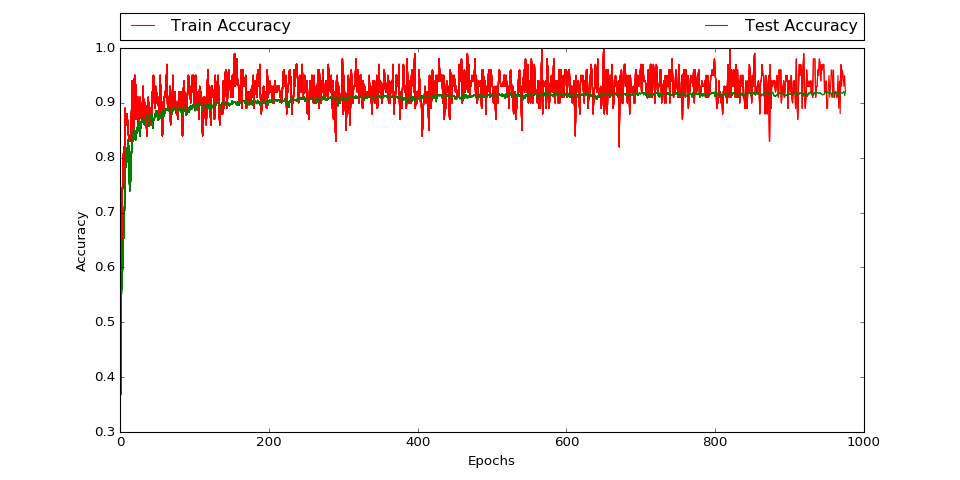

CPU times: user 27.5 s, sys: 8.17 s, total: 35.7 s
Wall time: 22.4 s


In [65]:
%%time
%matplotlib notebook
fig = plt.figure(figsize=(12,6), dpi=80)
ax = plt.subplot(111)
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
train_accuracies = []
test_accuracies = []
for i in range(1000):
    batch_xs, batch_ys = data_sets.train.next_batch(100)
    sess.run(train_step, feed_dict={x:batch_xs, t:batch_ys})
    train_accuracy_value = sess.run(accuracy, feed_dict={x:batch_xs, t: batch_ys})
    test_accuracy_value = sess.run(accuracy, feed_dict={x:data_sets.test.images, t: data_sets.test.labels})
    train_accuracies.append(train_accuracy_value)
    test_accuracies.append(test_accuracy_value)
    # those graph updates really decrease the speed of execution
    if i%25 ==0:
        train_line, = ax.plot(range(i+1), train_accuracies, 'r-', label='Train Accuracy')
        test_line, = ax.plot(range(i+1), test_accuracies, 'g-', label='Test Accuracy')
        ax.legend(handles=[train_line, test_line],
                      bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
        fig.canvas.draw()

# MNIST TensorFlow Mechanics 101
https://www.tensorflow.org/versions/r0.12/tutorials/mnist/tf/index.html

In [72]:
import math
import time

In [129]:
FLAGS.input_data_dir = "/mnt/data2/shalaby/tensorflow/mnist/input_data"
FLAGS.logs_dir = "/mnt/data2/shalaby/tensorflow/mnist/logs/tf-mechanics"
FLAGS.batch_size = 100
FLAGS.hidden1 = 128
FLAGS.hidden2 = 32
FLAGS.max_steps = 2000
FLAGS.learning_rate = 0.01
FLAGS.num_classes = 10
FLAGS.fake_data = False

In [130]:
data_sets = input_data.read_data_sets(FLAGS.input_data_dir, fake_data=FLAGS.fake_data)

Extracting /mnt/data2/shalaby/tensorflow/mnist/input_data/train-images-idx3-ubyte.gz
Extracting /mnt/data2/shalaby/tensorflow/mnist/input_data/train-labels-idx1-ubyte.gz
Extracting /mnt/data2/shalaby/tensorflow/mnist/input_data/t10k-images-idx3-ubyte.gz
Extracting /mnt/data2/shalaby/tensorflow/mnist/input_data/t10k-labels-idx1-ubyte.gz


In [131]:
images_placeholder = tf.placeholder(tf.float32, shape=(FLAGS.batch_size, mnist.IMAGE_PIXELS))
labels_placeholder = tf.placeholder(tf.int32, shape=(FLAGS.batch_size))

<b>Inference</b>

In [132]:
# Hidden 1
with tf.name_scope('hidden1'):
    # near 0 weights
    weights = tf.Variable(initial_value=tf.truncated_normal([mnist.IMAGE_PIXELS, FLAGS.hidden1], 
                                                            stddev=1.0/math.sqrt(float(mnist.IMAGE_PIXELS))),
                         name='weights')
    biases = tf.Variable(initial_value=tf.zeros([FLAGS.hidden1]), name='biases')
    z = tf.add(tf.matmul(images_placeholder, weights), biases)
    hidden1 = tf.nn.relu(z)

# Hidden 1
with tf.name_scope('hidden2'):
    # near 0 weights
    weights = tf.Variable(initial_value=tf.truncated_normal([FLAGS.hidden1, FLAGS.hidden2], 
                                                            stddev=1.0/math.sqrt(float(FLAGS.hidden1))),
                         name='weights')
    biases = tf.Variable(initial_value=tf.zeros(FLAGS.hidden2), name='biases')
    z = tf.add(tf.matmul(hidden1, weights), biases)
    hidden2 = tf.nn.relu(z)
    
# Linear
with tf.name_scope('linear'):
    weights = tf.Variable(initial_value=tf.truncated_normal([FLAGS.hidden2, FLAGS.num_classes], 
                                                            stddev=1.0/math.sqrt(float(FLAGS.hidden2))),
                         name='weights')
    biases = tf.Variable(initial_value=tf.zeros(FLAGS.num_classes), name='biases')
    logits = tf.add(tf.matmul(hidden2, weights), biases)

<b>Loss</b>

In [133]:
labels = tf.to_int64(labels_placeholder)
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels, name='xentropy')
loss = tf.reduce_mean(cross_entropy, name='xentropy_mean')

<b>Training</b>

In [134]:
optimizer = tf.train.GradientDescentOptimizer(FLAGS.learning_rate)
global_step = tf.Variable(0, name='global_step', trainable=False)
train_step = optimizer.minimize(loss, global_step=global_step)

<b>Evaluation</b>

In [135]:
correct = tf.nn.in_top_k(logits, labels, 1)
# Return the number of true entries.
eval_correct = tf.reduce_sum(tf.cast(correct, tf.int32))

<b>Actual Loop</b>

In [136]:
init = tf.global_variables_initializer()

In [137]:
sess.run(init)

In [138]:
def fill_feed_dict(data_set, images_pl, labels_pl):
    """Fills the feed_dict for training the given step.
    A feed_dict takes the form of:
    feed_dict = {
      <placeholder>: <tensor of values to be passed for placeholder>,
      ....
    }
    Args:
    data_set: The set of images and labels, from input_data.read_data_sets()
    images_pl: The images placeholder, from placeholder_inputs().
    labels_pl: The labels placeholder, from placeholder_inputs().
    Returns:
    feed_dict: The feed dictionary mapping from placeholders to values.
    """
    # Create the feed_dict for the placeholders filled with the next
    # `batch size` examples.
    images_feed, labels_feed = data_set.next_batch(FLAGS.batch_size,
                                                 FLAGS.fake_data)
    feed_dict = {
      images_pl: images_feed,
      labels_pl: labels_feed
    }
    return feed_dict

In [141]:
def do_eval(sess, eval_correct, images_placeholder, labels_placeholder, data_set):
    true_count = 0  # Counts the number of correct predictions.
    steps_per_epoch = data_set.num_examples // FLAGS.batch_size
    num_examples = steps_per_epoch * FLAGS.batch_size
    for step in xrange(steps_per_epoch):
        feed_dict = fill_feed_dict(data_set,
                                   images_placeholder,
                                   labels_placeholder)
        true_count += sess.run(eval_correct, feed_dict=feed_dict)
    precision = float(true_count) / num_examples
    print('  Num examples: %d  Num correct: %d  Precision @ 1: %0.04f' %
        (num_examples, true_count, precision))

In [142]:
for step in xrange(FLAGS.max_steps):
    start_time = time.time()
    
    feed_dict = fill_feed_dict(data_sets.train,
                                 images_placeholder,
                                 labels_placeholder)
    
    _, loss_value = sess.run([train_step, loss],
                             feed_dict=feed_dict)
    
    duration = time.time() - start_time
    
    if step % 100 == 0:
        print 'Step %d: loss = %.2f (%.3f sec)' % (step, loss_value, duration)
        print('Training Data Eval:')
        do_eval(sess,
                eval_correct,
                images_placeholder,
                labels_placeholder,
                data_sets.train)
        # Evaluate against the validation set.
        print('Validation Data Eval:')
        do_eval(sess,
                eval_correct,
                images_placeholder,
                labels_placeholder,
                data_sets.validation)
        # Evaluate against the test set.
        print('Test Data Eval:')
        do_eval(sess,
                eval_correct,
                images_placeholder,
                labels_placeholder,
                data_sets.test)
        

Step 0: loss = 0.56 (0.005 sec)
Training Data Eval:
  Num examples: 55000  Num correct: 49187  Precision @ 1: 0.8943
Validation Data Eval:
  Num examples: 5000  Num correct: 4496  Precision @ 1: 0.8992
Test Data Eval:
  Num examples: 10000  Num correct: 8984  Precision @ 1: 0.8984
Step 100: loss = 0.29 (0.001 sec)
Training Data Eval:
  Num examples: 55000  Num correct: 49365  Precision @ 1: 0.8975
Validation Data Eval:
  Num examples: 5000  Num correct: 4505  Precision @ 1: 0.9010
Test Data Eval:
  Num examples: 10000  Num correct: 9006  Precision @ 1: 0.9006
Step 200: loss = 0.35 (0.078 sec)
Training Data Eval:
  Num examples: 55000  Num correct: 49363  Precision @ 1: 0.8975
Validation Data Eval:
  Num examples: 5000  Num correct: 4510  Precision @ 1: 0.9020
Test Data Eval:
  Num examples: 10000  Num correct: 9017  Precision @ 1: 0.9017
Step 300: loss = 0.36 (0.001 sec)
Training Data Eval:
  Num examples: 55000  Num correct: 49397  Precision @ 1: 0.8981
Validation Data Eval:
  Num exa

In [143]:
sess.close()